In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import os
import shutil

In [2]:
# Acces teh Dataset
import os

#list all files in the input directory
input_dir = '/kaggle/input/cassava-leaf-disease-classification'
os.listdir(input_dir)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
import pandas as pd
import json

# Load the train.csv file
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))

# Load the JSON file for mapping labels to diseases
with open(os.path.join(input_dir, 'label_num_to_disease_map.json')) as f:
    label_map = json.load(f)

# Display the first few rows of the training data
print(train_df.head())

# Display the label mapping
print(label_map)


         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


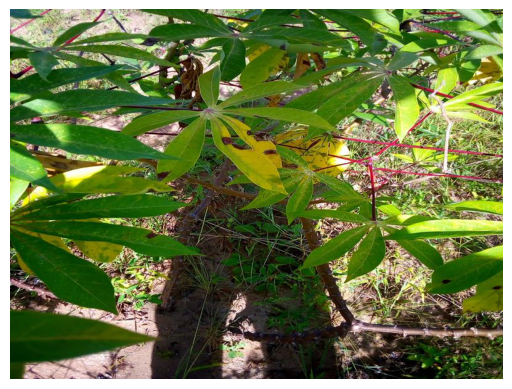

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to load and display an image
def load_and_display_image(image_id):
    image_path = os.path.join(input_dir, 'train_images', image_id)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Display a sample image
sample_image_id = train_df['image_id'].iloc[0]
load_and_display_image(sample_image_id)


In [5]:
from PIL import Image
from torchvision import transforms

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load an image using PIL
def load_image(image_id):
    image_path = os.path.join('/kaggle/input/cassava-leaf-disease-classification/train_images', image_id)
    img = Image.open(image_path)
    return img

# Example: Load and preprocess the sample image
sample_image_id = train_df['image_id'].iloc[0]  # Replace with actual image ID if needed
img = load_image(sample_image_id)               # Load image
img_tensor = preprocess(img)                    # Apply preprocessing transformations

# Check the shape of the processed image tensor
print(img_tensor.shape)


torch.Size([3, 224, 224])


In [6]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the custom dataset class
class CassavaDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to CSV and image directory
csv_file = '/kaggle/input/cassava-leaf-disease-classification/train.csv'
img_dir = '/kaggle/input/cassava-leaf-disease-classification/train_images'

# Create the dataset
train_dataset = CassavaDataset(csv_file=csv_file, img_dir=img_dir, transform=preprocess)

# Create the DataLoader
batch_size = 32
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Example usage (loop through one batch of data)
for images, labels in dataloader:
    print(images.shape, labels.shape)  # Should print: torch.Size([32, 3, 224, 224]), torch.Size([32])
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])
